### Navie Bayes

#### 1.贝叶斯方法  
贝叶斯方法是以贝叶斯原理为基础，使用概率统计的知识对样本数据集进行分类。由于其有着坚实的数学基础，贝叶斯分类算法的误判率是很低的。贝叶斯方法的特点是结合先验概率和后验概率，即避免了只使用先验概率的主观偏见，也避免了单独使用样本信息的过拟合现象。贝叶斯分类算法在数据集较大的情况下表现出较高的准确率，同时算法本身也比较简单。


#### 2. 先验概率  
基于统计的概率，基于以往历史经验和分析得到，不依赖当前发生的条件  
先验概率：P（A）  
计算先验概率：P（A）= 事件A发生的次数 / 样本总数

#### 3.条件概率  
记事件A发生的概率为P(A)，事件B发生的概率为P(B)，则在B事件发生的前提下，A事件发生的概率即为条件概率，记为P(A|B)  
数学公式为：
$$P(A|B) = \frac{P(A \cap B)}{P(B)}$$

#### 4.后验概率  
在贝叶斯统计中，后验概率是在考虑新信息之后事件发生的修正或更新概率。 后验概率通过使用贝叶斯定理更新先验概率来计算。 用统计术语来说，后验概率是假设事件B已经发生的情况下事件A发生的概率  
给定B发生的情况下，计算A发生后验概率的公式：  
$$P(A|B) = \frac{P(A \cap B)}{P(B)} = \frac{P(B|A)P(A)}{P(B)}$$

#### 5. 朴素贝叶斯公式  
朴素贝叶斯分类器的原理基于贝叶斯定理，即根据已知类别的数据来估计特征与类别之间的概率分布，然后使用这些概率来对新样本进行分类

$$
P(y|x) = \frac{P(x|y)P(y)}{P(x)}$$



#### 6.算法步骤  
- 统计样本数据
- 计算先验概率
- 计算条件概率
- 根据待预测样本所包含的特征，对不同类分别进行后验概率计算
- 将每个类别下计算得到的后验概率进行比较，选择具有最大后验概率的类别作为预测结果

#### 7.模型的超参数  
- alpha:拉普拉斯/利德斯通平滑系数
  - 作用：解决 “零概率问题”（某个特征在训练集中未出现，导致条件概率为 0）。$\alpha$=1 是拉普拉斯平滑，0<$\alpha$<1 是利德斯通平滑，$\alpha$=0 则无平滑。
  - 调整逻辑：$\alpha$ 越大，平滑程度越高，模型越保守；$\alpha$ 越小，越依赖训练数据，可能过拟合
- fit_prior:是否使用先验概率
  - 作用：是否基于训练数据的类别分布计算先验概率
  - 调整逻辑：如果样本类别分布不均衡，可能需要设置为 False 以避免模型偏向于多数类  
- class_prior: 手动指定类别的先验概率。当你有领域知识可以确定先验概率时，可手动传入一个数组（长度等于类别数），优先级高于fit_prior

In [12]:
import pandas as pd 
import numpy as np 
import jieba 
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt 
# 解决中文显示问题
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False   
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from gensim.models import Word2Vec

In [13]:
df = pd.read_csv(
    r'C:\Users\23017\Desktop\Machine Learning\Supervised Learning\data\comments_data.csv',
    encoding='gbk'
)
print(df.head())
print(f'评论总数量：{len(df["comments"])}')

                                            comments  sentiment
0  买来用做PS和Pr等，性能非常强大，外观非常好看，很轻很薄，界面颜色很好看，很流畅，视网膜屏...          0
1  按事情音质非常不错！屏幕分辨率焕然一新！第一次入手苹果生态！感觉好极了。键盘也很耐用爱了爱了...          0
2  性能非常强大，外观非常好看，很轻很薄，界面颜色很好看，很流畅，可以做多用途，京东自营肯定有正...          0
3  运行速度：非常快，屏幕效果：显示很细腻很爽啊！，散热性能：散热效果非常棒，外形外观：深空灰很...          0
4  很流畅，用的很舒服，音质真的强，运行速度：很快，屏幕效果：Nice，散热性能：比intel版...          0
评论总数量：10000


In [14]:
# 提取特征和标签
df = df[df['comments'].notna() & (df['comments'] != '')].reset_index(drop=True)  # 过滤空评论
X_raw = df['comments']  # 原始评论文本
y = df['sentiment']     # 标签（情感值）
print(f'过滤后有效评论数：{len(X_raw)}，标签数：{len(y)}')
print('前5个标签：\n', y.head())

过滤后有效评论数：10000，标签数：10000
前5个标签：
 0    0
1    0
2    0
3    0
4    0
Name: sentiment, dtype: int64


In [15]:
# 对评论内容进行分词
all_words = []
for sentence in X_raw:
    if sentence and isinstance(sentence, str):  # 确保是有效字符串
        words = jieba.lcut(sentence)
        all_words.append(words)
    else:
        all_words.append([])  # 空评论赋值空列表，保持样本数一致
print('第一条评论分词结果：', all_words[0])
print('完成分词')


第一条评论分词结果： ['买来', '用做', 'PS', '和', 'Pr', '等', '，', '性能', '非常', '强大', '，', '外观', '非常', '好看', '，', '很轻', '很', '薄', '，', '界面', '颜色', '很', '好看', '，', '很', '流畅', '，', '视网膜', '屏幕', '很', '不错', '，', '很', '舒适', '，', '比', '一般', '的', 'IPS', '屏幕', '好', '很多', '，', '散热', '很', '好']
完成分词


In [16]:
# 去除停用词
stopwords_file = r'C:\Users\23017\Desktop\Machine Learning\Supervised Learning\data\stopwords.txt'
# 按行读取停用词，过滤空行（避免停用词列表包含空字符串）
with open(stopwords_file, 'r', encoding='UTF-8') as fp:
    stop_words = [word.strip() for word in fp.read().split('\n') if word.strip() != '']
print('前100个停用词：\n', stop_words[0:100])

# 对每条评论去除停用词和空字符串
for idx in range(len(all_words)):
    all_words[idx] = [
        word for word in all_words[idx] 
        if word not in stop_words and word.strip() != ''
    ]
print('第一条评论去停用词后结果：', all_words[0])
print('完成去停用词')


前100个停用词：
 ['$', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '?', '_', '“', '”', '、', '。', '《', '》', '一', '一些', '一何', '一切', '一则', '一方面', '一旦', '一来', '一样', '一般', '一转眼', '万一', '上', '上下', '下', '不', '不仅', '不但', '不光', '不单', '不只', '不外乎', '不如', '不妨', '不尽', '不尽然', '不得', '不怕', '不惟', '不成', '不拘', '不料', '不是', '不比', '不然', '不特', '不独', '不管', '不至于', '不若', '不论', '不过', '不问', '与', '与其', '与其说', '与否', '与此同时', '且', '且不说', '且说', '两者', '个', '个别', '临', '为', '为了', '为什么', '为何', '为止', '为此', '为着', '乃', '乃至', '乃至于', '么', '之', '之一', '之所以', '之类', '乌乎', '乎', '乘', '也', '也好', '也罢', '了', '二来', '于', '于是', '于是乎']
第一条评论去停用词后结果： ['买来', '用做', 'PS', 'Pr', '性能', '强大', '外观', '好看', '很轻', '薄', '界面', '颜色', '好看', '流畅', '视网膜', '屏幕', '不错', '舒适', 'IPS', '屏幕', '散热']
完成去停用词


In [17]:
model_path = r'C:\Users\23017\Desktop\Machine Learning\Supervised Learning\data\word2vec.model'
word2vec_model = Word2Vec.load(model_path)
sentences_vector = []
vec_size = word2vec_model.wv.vector_size  # 获取词向量维度
print(f'词向量维度：{vec_size}')

for sentence in all_words:
    sentence_vector = np.zeros(vec_size)  # 初始化空的句向量
    if len(sentence) > 0:  # 避免空评论除以0报错
        word_vectors = [word2vec_model.wv.get_vector(word) for word in sentence]
        sentence_vector = np.sum(word_vectors, axis=0) / len(sentence)  # 求和后取平均
    sentences_vector.append(sentence_vector)

词向量维度：100


In [18]:
sentences_vector = np.array(sentences_vector)
print('评论转句向量完成，句向量矩阵维度：', sentences_vector.shape)  
print('最后一条评论的句向量前10个值：', sentences_vector[-1][:10])

评论转句向量完成，句向量矩阵维度： (10000, 100)
最后一条评论的句向量前10个值： [-0.15400222  0.5250858   0.09092486 -0.30232486 -0.13292767 -0.4801174
 -0.05214748  0.70720965 -0.04798342 -0.3103991 ]


In [19]:
from sklearn.preprocessing import MinMaxScaler
#由于词向量可能存在负值，而朴素贝叶斯无法输入负值，因此将其归一化到[0,1]区间
scaler = MinMaxScaler()
X_scaler = scaler.fit_transform(sentences_vector)  # 所有值缩放到0-1之间，消除负数
#划分训练集和测试集
X = X_scaler 
# 测试集30%，训练集70%，随机种子42保证结果可复现，
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print('训练集/测试集划分成功')
print(f'训练集特征维度：{X_train.shape}，训练集标签数量：{y_train.shape}')  
print(f'测试集特征维度：{X_test.shape}，测试集标签数量：{y_test.shape}')  

训练集/测试集划分成功
训练集特征维度：(7000, 100)，训练集标签数量：(7000,)
测试集特征维度：(3000, 100)，测试集标签数量：(3000,)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
最优超参数组合: {'alpha': 5.0, 'fit_prior': True}
交叉验证最优F1分数: 0.8817
朴素贝叶斯训练花费时间: 0.2589秒
训练集准确率: 0.8810
测试集准确率: 0.8740
预测花费时间: 0.0070秒


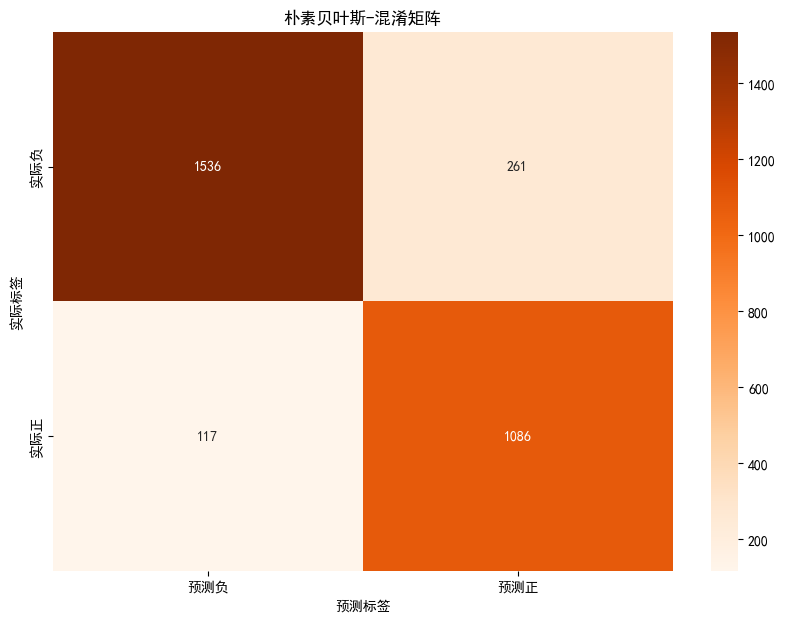

F1 Score: 0.8518


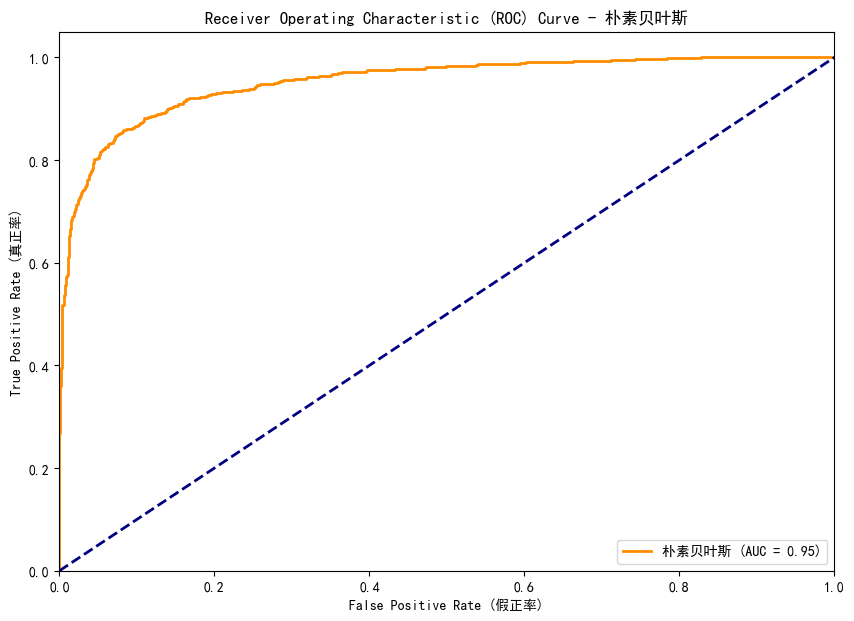

In [ ]:
# 朴素贝叶斯
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc
import time

# 初始化计时
start = time.time()

# 超参数寻优 
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],  # 平滑参数
    'fit_prior': [True, False]  # 是否使用先验概率
}

nb_model = MultinomialNB()
grid_search = GridSearchCV(
  estimator=nb_model,
  param_grid=param_grid,
  cv=5,  # 5折交叉验证
  scoring='f1_weighted',  # 加权F1值，适合二分类
  verbose=1,  # 显示搜索进度
  n_jobs=-1  # 使用所有CPU核心并行计算
)

grid_search.fit(X_train, y_train)
print(f"最优超参数组合: {grid_search.best_params_}")
print(f"交叉验证最优F1分数: {grid_search.best_score_:.4f}")

best_nb_model = grid_search.best_estimator_
end = time.time()
print('朴素贝叶斯训练花费时间: {:.4f}秒'.format(end - start))


# 模型预测与评分（训练集+测试集）
start = time.time()
train_score = best_nb_model.score(X_train, y_train)  # 训练集准确率
test_score = best_nb_model.score(X_test, y_test)      # 测试集准确率
end = time.time()
# 输出准确率和预测耗时
print('训练集准确率: {:.4f}'.format(train_score))
print('测试集准确率: {:.4f}'.format(test_score))
print('预测花费时间: {:.4f}秒'.format(end - start))

# 测试集预测结果（类别）
y_pred = best_nb_model.predict(X_test)
# 测试集预测概率（正例概率，[:,1]取第二列，对应正例）
bn_pred_prob = best_nb_model.predict_proba(X_test)[:, 1]

# 绘制混淆矩阵（评估分类精准度：真负/假正/假负/真正）
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(
    cm,
    annot=True,  # 显示数值
    fmt='d',     # 数值格式为整数
    cmap='Oranges',
    xticklabels=['预测负', '预测正'],
    yticklabels=['实际负', '实际正']
)
plt.xlabel('预测标签')
plt.ylabel('实际标签')
plt.title('朴素贝叶斯-混淆矩阵')
plt.show()

# 输出F1分数（兼顾精确率和召回率，比准确率更适合不平衡数据）
print('F1 Score: {:.4f}'.format(f1_score(y_test, y_pred)))

# 绘制ROC曲线并计算AUC值（评估模型区分能力，AUC越接近1越好）
fpr_bayes, tpr_bayes, _ = roc_curve(y_test, bn_pred_prob)  # 计算假正率/真正率
roc_auc_bayes = auc(fpr_bayes, tpr_bayes)                      # 计算AUC值

plt.figure(figsize=(10, 7))
# 绘制ROC曲线
plt.plot(
    fpr_bayes, tpr_bayes,
    color='darkorange',
    lw=2,
    label='朴素贝叶斯 (AUC = %0.2f)' % roc_auc_bayes
)
# 绘制随机猜测基准线（对角线）
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# 坐标轴范围
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
# 坐标轴标签和标题
plt.xlabel('False Positive Rate (假正率)')
plt.ylabel('True Positive Rate (真正率)')
plt.title('Receiver Operating Characteristic (ROC) Curve - 朴素贝叶斯')
plt.legend(loc="lower right")  # 图例位置
plt.show()


In [22]:
#抽取50条进行检验
import random

y_test = y_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)


test_total = len(X_test)
sample_num = 50  # 抽取样本数
# 限制start范围：0 ≤ start ≤ 测试集长度-50，若测试集不足50条，直接取全部
if test_total < sample_num:
    start = 0
    sample_num = test_total
    print(f"测试集仅{test_total}条数据，不足50条，将抽取全部数据测试")
else:
    start = random.randint(0, test_total - sample_num)  # 修正原100-2400的硬编码，适配任意测试集长度

# 抽取50条数据（特征+标签），因已重置索引，切片后样本完全匹配
X_data = X_test[start:start+sample_num]
y_data = y_test[start:start+sample_num]
success_test = 0


for sequence_index in range(len(X_data)):
 
    comment_words = all_words[start + sequence_index]
    # 拼接分词结果输出（处理空评论情况）
    comment_str = '/'.join(comment_words) if comment_words else '【空评论】'
    print(f"评论分词结果：{comment_str}")
    # 模型预测（传入二维数组，适配sklearn要求）
    x_sample = X_data[sequence_index:sequence_index+1]  
    res = best_nb_model.predict(x_sample)[0]  # 取预测结果的标量值（0/1）
    # 【关键修正5】标签用数值类型0/1判断，与模型训练/预测结果一致
    # 输出预测结果
    if res == 0:             
        print('Predict result : 好评', end='\t')             
    else:              
        print('Predict result : 差评', end='\t')            
    # 输出实际结果（y_data已重置索引，直接用位置索引访问，数值类型）
    y_actual = y_data.iloc[sequence_index]  # 用iloc确保位置访问，兼容Series
    if y_actual == 0:
        print('Actual results: 好评', end='\t')
    else:   
        print('Actual results: 差评', end='\t')
    # 判断预测是否正确
    if res == y_actual:
        print('Predict success!', end='\t')
        success_test += 1
    else:
        print('Predict fail!', end='\t')
    print('\n' + '-'*80 + '\n')  
# 计算并输出预测准确度
accuracy = success_test / sample_num
print(f'本次朴素贝叶斯测试共抽取{sample_num}条数据，预测准确度为: {accuracy:.4f}（{success_test}/{sample_num}）')

评论分词结果：电脑/外观/好看/屏/设计/快/不卡顿/带有/指纹/解锁/背光/键盘/满意
Predict result : 差评	Actual results: 好评	Predict fail!	
--------------------------------------------------------------------------------

评论分词结果：电脑/终于/收到/宝贝/运行/流畅/孩子/上网/课/孩子/喜欢
Predict result : 好评	Actual results: 好评	Predict success!	
--------------------------------------------------------------------------------

评论分词结果：电脑/很漂亮/华为/系统/设计/感/很棒/隐藏/键盘/摄像头/电源/键/指纹识别/好多/东西/开发/哈哈哈/鹅/满意/几个/软件/换/壁纸/慢慢/试它
Predict result : 差评	Actual results: 差评	Predict success!	
--------------------------------------------------------------------------------

评论分词结果：性价比/高/配置/牌子/4200/4500/金属外壳/灰色/显/大气/厚度/华为/牌子/真的/挺不错/日常/办公/真的/推荐
Predict result : 差评	Actual results: 好评	Predict fail!	
--------------------------------------------------------------------------------

评论分词结果：下单/第二天/收到/物流/很快/质量/华为/不愧为/品牌/档次/高/运营/速度/很快/办公/够用/支持/华为
Predict result : 差评	Actual results: 差评	Predict success!	
--------------------------------------------------------------------------------

评论分词结果：运行/速度

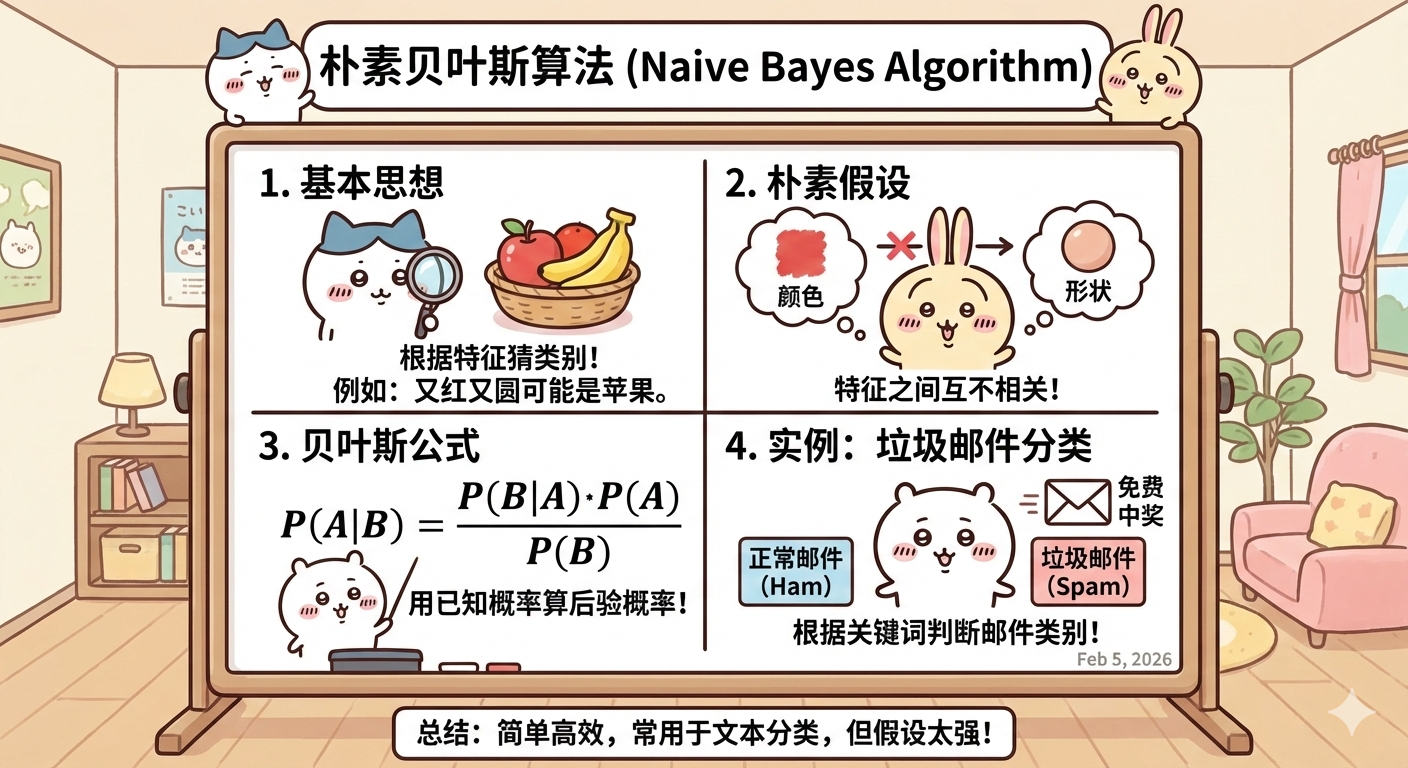